# Histopathologic Cancer Detection with CNN

### The problem and data

This project focuses on creating an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. In this dataset, we are provided with a large number of small pathology images to classify. Files are named with an image id. The *train_labels.csv* file provides the ground truth for the images in the train folder. We need to predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

In this project, we will explore the data, create two CNN models, fit the models into data, and finally compare their performance and select the model. 

In [1]:
# General libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
import fnmatch
import random
os.system('pip install visualkeras')
import visualkeras
import cv2 as cv

#Model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, ZeroPadding2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 3.7 MB/s eta 0:00:00


### Explore the data folder structure
Here we are going to explore the data folder structure and load the names of the image files into **train_data** and **test_data**

In [2]:
#list the data folder structure
os.listdir('../input/histopathologic-cancer-detection/')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [3]:
# Count number of tif images in train and test folders 
train_path = '../input/histopathologic-cancer-detection/train/'
test_path = '../input/histopathologic-cancer-detection/test/'
print("# of TIFF images in train folder = ",len(fnmatch.filter(os.listdir(train_path), '*.*')))
print("# of TIFF images in test folder = ",len(fnmatch.filter(os.listdir(test_path), '*.*')))


# of TIFF images in train folder =  220025
# of TIFF images in test folder =  57458


In [4]:
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')

test_data = pd.DataFrame({'id':os.listdir(test_path)})



### Exploratory Data Analysis

In [5]:
print("---------- train data ---------------")
print(train_data.head())
train_data['id'] = train_data['id'] + '.tif'
train_data['label'] = train_data['label'].astype(str)
print("---------- train data (after appending file extension)---------------")
print(train_data.head())
print("---------- test data ---------------")
print(test_data.head())

print(train_data.shape)

print(train_data.info())

print(train_data.label.unique())

---------- train data ---------------
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
---------- train data (after appending file extension)---------------
                                             id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0
---------- test data ---------------
                                             id
0  a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3  bd953a3b1db1f7041ee95ff482594c

### Data Visualizations

From above EDA we noticed there are only two distinct values avaible in label column 0 and 1, which represents **non-cancerous** and **canerous** respectively.
Here we would like to render a pie chart to get a sense on the percentage for these two categories.

0    130908
1     89117
Name: label, dtype: int64


([<matplotlib.patches.Wedge at 0x7fadd512d3d0>,
 [Text(-0.32334109228524116, 1.051404079333815, '0-Non-cancerous'),
  Text(0.3233409938456856, -1.0514041096071884, '1-Cancerous')],
 [Text(-0.17636786851922245, 0.5734931341820809, '59.50%'),
  Text(0.1763678148249194, -0.57349315069483, '40.50%')])

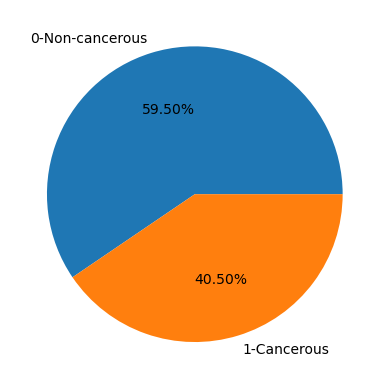

In [6]:
unique_counts = train_data['label'].value_counts()
print(unique_counts)

plt.pie(unique_counts.tolist(), 
        labels = ['0-Non-cancerous','1-Cancerous'],
        autopct='%1.2f%%'
       )


Pie chart reveals the percentage of two categories 0-Non-cancerous and 1-Cancerous are 59.50% and 40.50% respectively.

Some sample images from the train data are also randomly presented below:

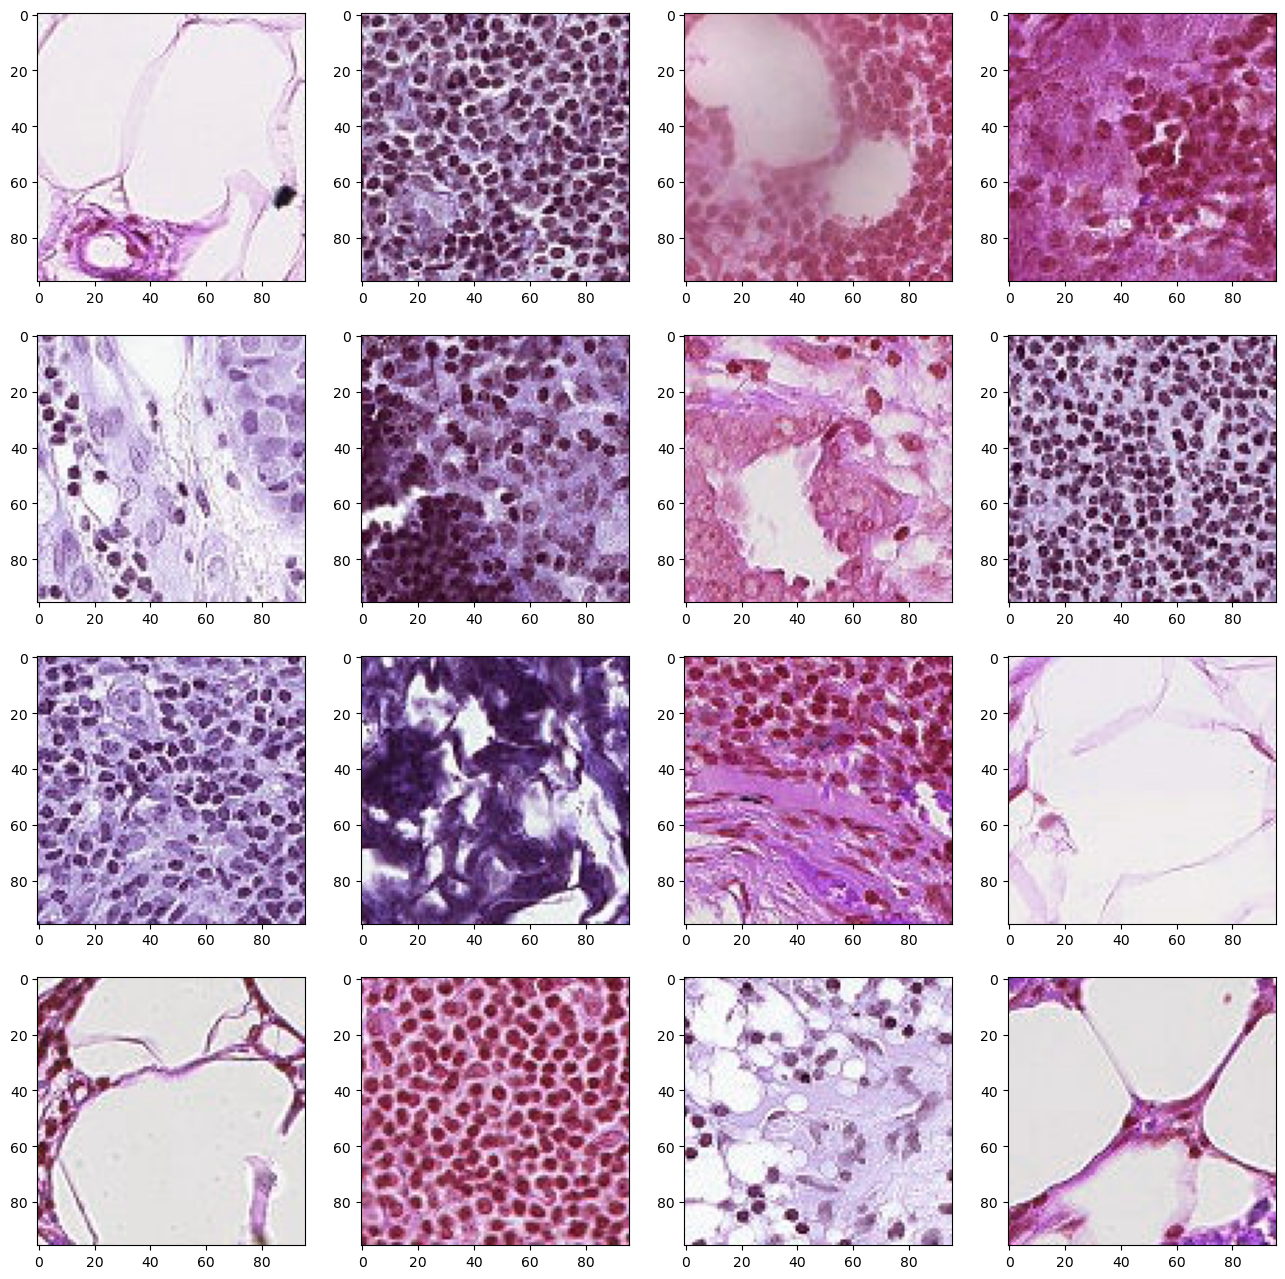

In [7]:
plt.figure(1, figsize=(16, 16))
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(train_data.id)
  imgs = cv.imread(train_path+random_img)
  plt.subplot(4, 4, n)
  plt.imshow(imgs)

### Model Architecture

We will be using convolutional neural network (CNN) to solve this binary classification problem:


The first model will start with a typical structure like: input --> Conv2D --> Conv2D --> MaxPool --> Conv2D --> Conv2D --> MaxPool --> Flatten --> Output.  Relu activation on hiden layers and sigmoid activation on the output layer.

Images will be normalized by taking the pixels and dividing each pixel by 255 to have values between 0-1.

The second model will repeat Conv2D --> Conv2D --> MaxPool one more round and add dropout and batch nomalization to avoid overfit.

A text summary and diagram of the model architecture will be printed after the model construct for better presentation.

In [8]:
# set model constants
batchSize = 256

In [9]:
# modify training data by normalizing it 
# and split data into training and validation sets
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

In [10]:
# generate training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=batchSize,
    seed=985723,
    class_mode="binary",
    target_size=(64,64))  

Found 187022 validated image filenames belonging to 2 classes.


In [11]:
# generate validation data
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=batchSize,
    seed=985723,
    class_mode="binary",
    target_size=(64,64))  

Found 33003 validated image filenames belonging to 2 classes.


**Model 1 construct**

In [12]:
# tpu = None
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError:
#     strategy = tf.distribute.get_strategy()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (256, 62, 62, 16)         448       
                                                                 
 conv2d_1 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d (MaxPooling2D  (256, 30, 30, 16)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (256, 28, 28, 32)         4640      
                                                                 
 conv2d_3 (Conv2D)           (256, 26, 26, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (256, 13, 13, 32)        0         
 2D)                                                    

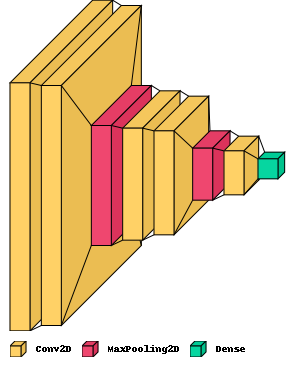

In [13]:
model1_auc = tf.keras.metrics.AUC()


# with tpu_strategy.scope():    
#create model
model1 = Sequential()

model1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))

#build model by input size
model1.build(input_shape=(batchSize, 64, 64, 3))

#compile
adam_optimizer = Adam(learning_rate=0.0001)
model1.compile(loss='binary_crossentropy', metrics=['accuracy', model1_auc], optimizer=adam_optimizer)

#Summary of model
model1.summary()

visualkeras.layered_view(model1, type_ignore=[ZeroPadding2D, Flatten], legend=True)

In [14]:
EPOCHS = 10
# train the model
history_model1 = model1.fit(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

Epoch 1/10
731/731 [==============================] - 1879s 3s/step - loss: 0.4964 - accuracy: 0.7591 - auc: 0.8322 - val_loss: 0.4618 - val_accuracy: 0.7892 - val_auc: 0.8568
Epoch 2/10
731/731 [==============================] - 1156s 2s/step - loss: 0.4548 - accuracy: 0.7912 - auc: 0.8615 - val_loss: 0.4371 - val_accuracy: 0.8009 - val_auc: 0.8719
Epoch 3/10
731/731 [==============================] - 1274s 2s/step - loss: 0.4319 - accuracy: 0.8043 - auc: 0.8756 - val_loss: 0.4324 - val_accuracy: 0.8076 - val_auc: 0.8884
Epoch 4/10
731/731 [==============================] - 1451s 2s/step - loss: 0.4122 - accuracy: 0.8153 - auc: 0.8873 - val_loss: 0.4108 - val_accuracy: 0.8173 - val_auc: 0.8953
Epoch 5/10
731/731 [==============================] - 1140s 2s/step - loss: 0.3994 - accuracy: 0.8226 - auc: 0.8946 - val_loss: 0.3895 - val_accuracy: 0.8275 - val_auc: 0.9019
Epoch 6/10
731/731 [==============================] - 1115s 2s/step - loss: 0.3933 - accuracy: 0.8256 - auc: 0.8983 - va

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


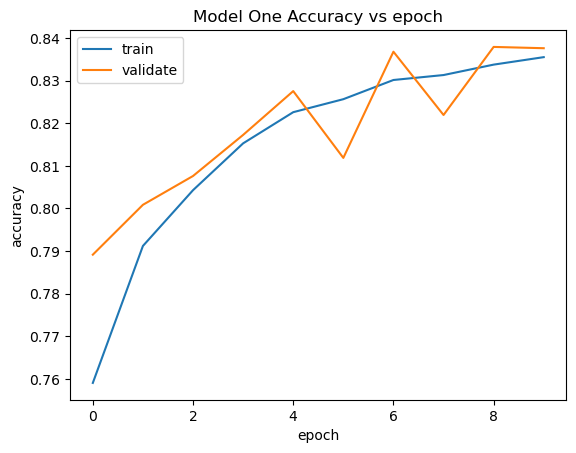

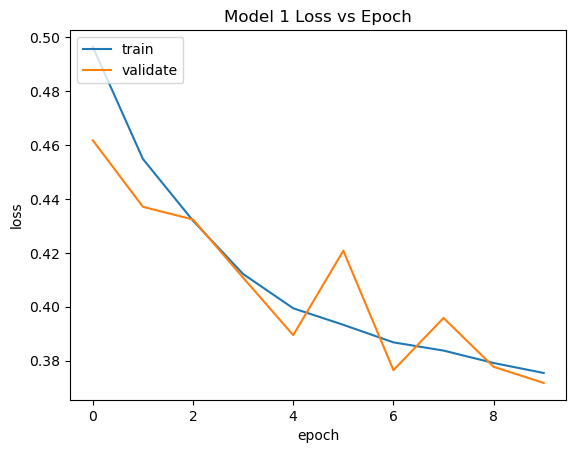

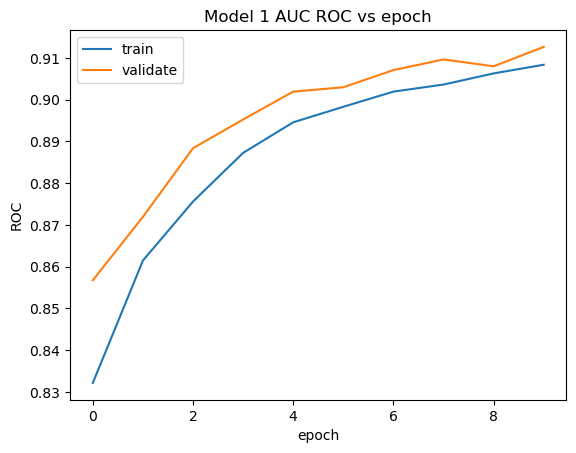

In [15]:
print(history_model1.history.keys())

# plot model accuracy per epoch 
plt.plot(history_model1.history['accuracy'])
plt.plot(history_model1.history['val_accuracy'])
plt.title('Model One Accuracy vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history_model1.history['loss'])
plt.plot(history_model1.history['val_loss'])
plt.title('Model 1 Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model ROC per epoch
plt.plot(history_model1.history['auc'])
plt.plot(history_model1.history['val_auc'])
plt.title('Model 1 AUC ROC vs epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

**Model build 2**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (256, 62, 62, 16)         448       
                                                                 
 conv2d_6 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (256, 30, 30, 16)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (256, 30, 30, 16)         0         
                                                                 
 batch_normalization (BatchN  (256, 30, 30, 16)        64        
 ormalization)                                                   
                                                                 
 conv2d_7 (Conv2D)           (256, 28, 28, 32)        

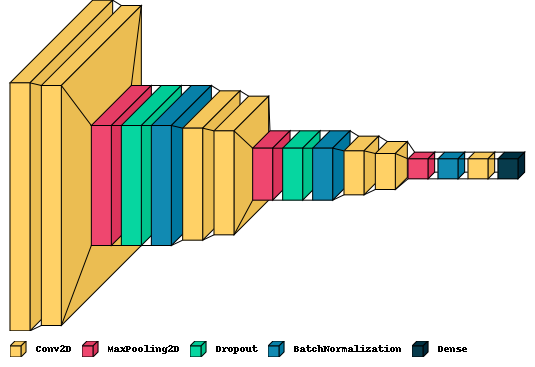

In [16]:
model2_auc = tf.keras.metrics.AUC()
    
# with tpu_strategy.scope():       
#create model
model2 = Sequential()

model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.1))

model2.add(BatchNormalization())
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.1))

model2.add(BatchNormalization())
model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(BatchNormalization())
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

#build model by input size
model2.build(input_shape=(batchSize, 64, 64, 3))

#compile
adam_optimizer = Adam(learning_rate=0.0001)
model2.compile(loss='binary_crossentropy', metrics=['accuracy', model2_auc], optimizer=adam_optimizer)

# Summary of the 2nd model
model2.summary()

visualkeras.layered_view(model2, type_ignore=[ZeroPadding2D, Flatten], legend=True)

In [17]:
EPOCHS = 10

# train model
history_model2 = model2.fit(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

Epoch 1/10
731/731 [==============================] - 1114s 2s/step - loss: 0.4824 - accuracy: 0.7719 - auc_1: 0.8419 - val_loss: 0.5765 - val_accuracy: 0.7421 - val_auc_1: 0.8658
Epoch 2/10
731/731 [==============================] - 1128s 2s/step - loss: 0.4159 - accuracy: 0.8162 - auc_1: 0.8844 - val_loss: 0.6253 - val_accuracy: 0.7432 - val_auc_1: 0.8852
Epoch 3/10
731/731 [==============================] - 1094s 1s/step - loss: 0.3902 - accuracy: 0.8297 - auc_1: 0.8996 - val_loss: 0.4741 - val_accuracy: 0.7928 - val_auc_1: 0.8980
Epoch 4/10
731/731 [==============================] - 1104s 2s/step - loss: 0.3748 - accuracy: 0.8367 - auc_1: 0.9081 - val_loss: 0.5114 - val_accuracy: 0.7792 - val_auc_1: 0.9044
Epoch 5/10
731/731 [==============================] - 1111s 2s/step - loss: 0.3624 - accuracy: 0.8422 - auc_1: 0.9146 - val_loss: 0.5217 - val_accuracy: 0.7758 - val_auc_1: 0.9137
Epoch 6/10
731/731 [==============================] - 1134s 2s/step - loss: 0.3521 - accuracy: 0.846

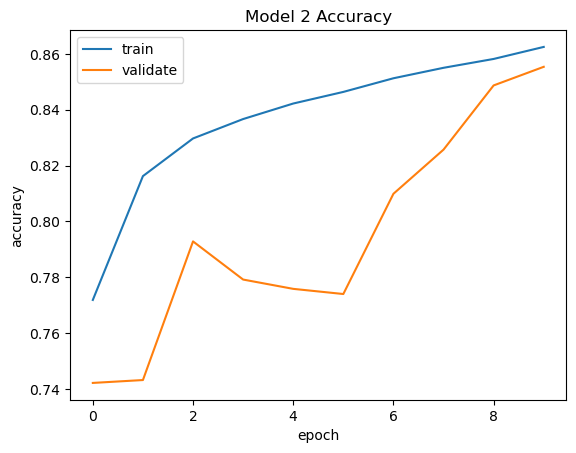

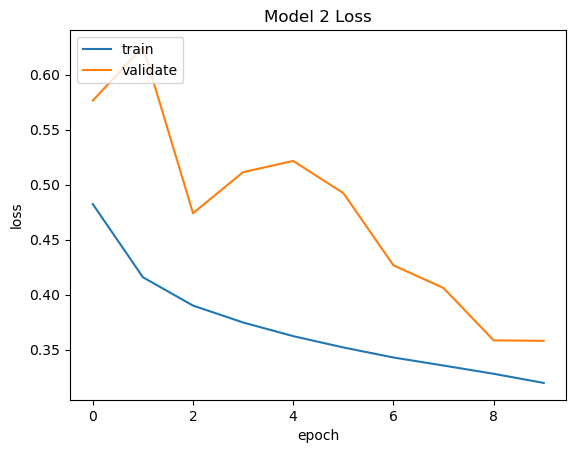

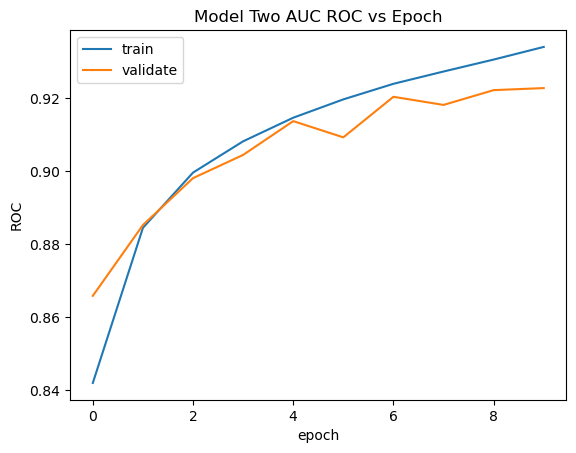

In [18]:
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history_model2.history['loss'])
plt.plot(history_model2.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history_model2.history['auc_1'])
plt.plot(history_model2.history['val_auc_1'])
plt.title('Model Two AUC ROC vs Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();


### Results and Analysis

From above plots for two models, we learned that both of them performed well. Since the second one has better accuracy and lower loss, we decide to choose the second one for prediction.

In [19]:
# test data
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [20]:
#prediction with model 2

predictions = model2.predict(test_generator, verbose=1)

57458/57458 [==============================] - 624s 11ms/step


In [21]:
#create submission
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


0    38991
1    18467
Name: label, dtype: int64


([<matplotlib.patches.Wedge at 0x7fadab5aa490>,
 [Text(-0.5853189225602203, 0.9313440604271565, '0-Non-cancerous'),
  Text(0.5853189225602206, -0.9313440604271563, '1-Cancerous')],
 [Text(-0.3192648668510292, 0.5080058511420853, '67.86%'),
  Text(0.3192648668510294, -0.5080058511420852, '32.14%')])

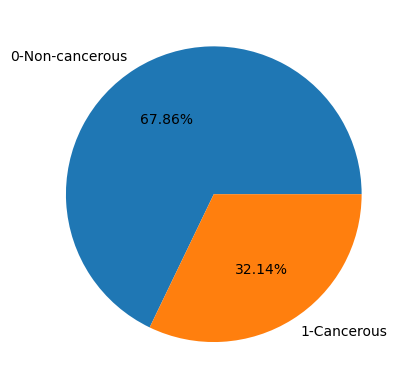

In [22]:
#Submission label pie chart
unique_counts = submission_df['label'].value_counts()
print(unique_counts)

plt.pie(unique_counts.tolist(), 
        labels = ['0-Non-cancerous','1-Cancerous'],
        autopct='%1.2f%%'
       )

In [23]:
#Competition Submission
submission_df.to_csv('submission.csv', index=False)

## Conclusion
CNN network model works very well in getting smaller training data without losing the critial features. With image normalization, less compution will be required. Regulation with dropout and batch normalization resolved overfitting problems.
Futher augmentation techniques like resizing, flipping, rotating, cropping, padding, can help to address issues like overfitting and data scarcity, and they make the model robust with better performance.